# SwAVの重み使わずゼロからResNet50学習
- SwAVの効果（SwAV_TF_Linear_evaluation との）比較用
- https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/linear_evaluation/Linear_Evaluation_10_Epochs.ipynb

In [1]:
import tensorflow as tf

@tf.function
def scale_resize_image(image_label):
    image, label = image_label["image"], image_label["label"]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return (image, label)

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os

from itertools import groupby
from tqdm import tqdm

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.1


In [3]:
# TPUの検出
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


# params

In [4]:
n_classes = 5  # キャッサバデータは5クラス

#BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BATCH_SIZE = 16

epochs = 100

patience = 15

#DEBUG = True
DEBUG = False
if DEBUG:
    epochs = 2

# Cassava data
- https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    return image

In [6]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return {"image": image, "label": label}
    idnum = example['image_name']
    return {"image": image, "label": idnum}

In [7]:
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

In [8]:
import re

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [9]:
#from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split

#GCS_PATH = KaggleDatasets().get_gcs_path()
#train_tfrecs = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec')

#train_tfrecs = tf.io.gfile.glob('../input/cassava-leaf-disease-classification/train_tfrecords/ld_train*.tfrec')
train_tfrecs = tf.io.gfile.glob(r'C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train_tfrecords\ld_train*.tfrec')

TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(train_tfrecs,
                                                       test_size=0.35, 
                                                       random_state=5)
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
print(f"NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES: {NUM_TRAINING_IMAGES}, {NUM_VALIDATION_IMAGES}")

NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES: 13380, 8017


In [10]:
train_ds = load_dataset(TRAINING_FILENAMES, labeled=True)
validation_ds = load_dataset(VALID_FILENAMES, labeled=True)

training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testing_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Get ResNet50

In [11]:
import tensorflow as tf
from tensorflow.keras import layers

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, 
    decay_steps=10000, 
    decay_rate=0.9)

def get_training_model(weights=None):
    inputs = layers.Input(shape=(224, 224, 3))
    
    EXTRACTOR = tf.keras.applications.ResNet50(weights=weights, 
                                               include_top=False, 
                                               input_shape=(224, 224, 3))
    
    if weights is None:
        x = EXTRACTOR(inputs, training=True)
    else:
        EXTRACTOR.trainable = False
        x = EXTRACTOR(inputs, training=False)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(n_classes, activation="softmax")(x)
    
    classifier = tf.keras.models.Model(inputs=inputs, outputs=x)
    
    classifier.compile(loss="sparse_categorical_crossentropy", 
                       metrics=["acc"],
                       optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
                      )
    
    return classifier

# imagenetの重み固定してResNet50学習

## Without Augmentation

In [12]:
%%time
# get model and compile
tf.keras.backend.clear_session()

# モデルがTPU上で確実に学習されるようにするために、 strategy.scope()を使用してモデルを構築
#with strategy.scope(): 
model = get_training_model(weights="imagenet")
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="imagenet_without_augment.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train 
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=epochs,
                    callbacks=[early_stopper, checkpoint],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE, 
                   )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
input_1 True
resnet50 False
global_average_pooling2d True
dense True

Epoch 1/100
836/836 [==============================] - 52s 62ms/step - loss: 1.4321 - acc: 0.4747 - val_loss: 1.2142 - val_acc: 0.6082
Epoch 2/100
836/836 [=========

836/836 [==============================] - 54s 64ms/step - loss: 1.1305 - acc: 0.6183 - val_loss: 1.1441 - val_acc: 0.6082
Epoch 55/100
836/836 [==============================] - 51s 61ms/step - loss: 1.1266 - acc: 0.6206 - val_loss: 1.1439 - val_acc: 0.6082
Epoch 56/100
836/836 [==============================] - 52s 62ms/step - loss: 1.1316 - acc: 0.6176 - val_loss: 1.1434 - val_acc: 0.6082
Epoch 57/100
836/836 [==============================] - 52s 62ms/step - loss: 1.1290 - acc: 0.6195 - val_loss: 1.1434 - val_acc: 0.6082
Epoch 58/100
836/836 [==============================] - 52s 62ms/step - loss: 1.1298 - acc: 0.6188 - val_loss: 1.1432 - val_acc: 0.6082
Epoch 59/100
836/836 [==============================] - 53s 63ms/step - loss: 1.1310 - acc: 0.6169 - val_loss: 1.1428 - val_acc: 0.6082
Epoch 60/100
836/836 [==============================] - 53s 64ms/step - loss: 1.1256 - acc: 0.6202 - val_loss: 1.1427 - val_acc: 0.6082
Epoch 61/100
836/836 [==============================] - 54s 6

<AxesSubplot:>

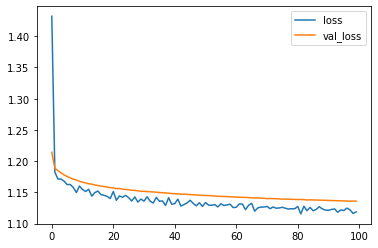

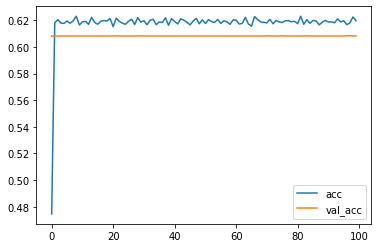

In [13]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [14]:
loss, acc = model.evaluate(testing_ds)

502/502 [==============================] - 17s 35ms/step - loss: 1.1358 - acc: 0.6083


## With Augmentation

In [15]:
# Configs
CROP_SIZE = 224
MIN_SCALE = 0.5
MAX_SCALE = 1.

# Experimental options
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_deterministic = False
options.experimental_threading.max_intra_op_parallelism = 1

In [16]:
@tf.function
def scale_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return (image, label)

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)
 
@tf.function
def random_resize_crop(image, label):
    # Conditional resizing
    image = tf.image.resize(image, (260, 260))
    # Get the crop size for given min and max scale
    size = tf.random.uniform(shape=(1,), minval=MIN_SCALE*260,
                             maxval=MAX_SCALE*260, dtype=tf.float32)
    size = tf.cast(size, tf.int32)[0]
    # Get the crop from the image
    crop = tf.image.random_crop(image, (size,size,3))
    crop_resize = tf.image.resize(crop, (CROP_SIZE, CROP_SIZE))

    return crop_resize, label

@tf.function
def tie_together(image_label):
    image, label = image_label["image"], image_label["label"]
    # Scale the pixel values
    image, label = scale_image(image , label)
    # random horizontal flip
    image = random_apply(tf.image.random_flip_left_right, image, p=0.5)
    # Random resized crops
    image, label = random_resize_crop(image, label)

    return image, label

In [17]:
training_ds = (
    train_ds
    .map(tie_together, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

training_ds = training_ds.with_options(options)

In [18]:
%%time
# get model and compile
tf.keras.backend.clear_session()

# モデルがTPU上で確実に学習されるようにするために、 strategy.scope()を使用してモデルを構築
#with strategy.scope(): 
model = get_training_model(weights="imagenet")
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="imagenet_augment.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train 
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=epochs,
                    callbacks=[early_stopper, checkpoint],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE, 
                   )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
input_1 True
resnet50 False
global_average_pooling2d True
dense True

Epoch 1/100
836/836 [==============================] - 49s 59ms/step - loss: 1.3257 - acc: 0.4734 - val_loss: 1.1865 - val_acc: 0.6082
Epoch 2/100
836/836 [=========

836/836 [==============================] - 48s 58ms/step - loss: 1.1255 - acc: 0.6220 - val_loss: 1.1549 - val_acc: 0.6082
Epoch 55/100
836/836 [==============================] - 49s 58ms/step - loss: 1.1310 - acc: 0.6196 - val_loss: 1.1552 - val_acc: 0.6082
Epoch 56/100
836/836 [==============================] - 49s 59ms/step - loss: 1.1336 - acc: 0.6177 - val_loss: 1.1544 - val_acc: 0.6082
Epoch 57/100
836/836 [==============================] - 48s 58ms/step - loss: 1.1349 - acc: 0.6172 - val_loss: 1.1538 - val_acc: 0.6082
Epoch 58/100
836/836 [==============================] - 48s 58ms/step - loss: 1.1304 - acc: 0.6195 - val_loss: 1.1535 - val_acc: 0.6082
Epoch 59/100
836/836 [==============================] - 48s 57ms/step - loss: 1.1320 - acc: 0.6186 - val_loss: 1.1536 - val_acc: 0.6082
Epoch 60/100
836/836 [==============================] - 49s 59ms/step - loss: 1.1330 - acc: 0.6178 - val_loss: 1.1523 - val_acc: 0.6082
Epoch 61/100
836/836 [==============================] - 49s 5

<AxesSubplot:>

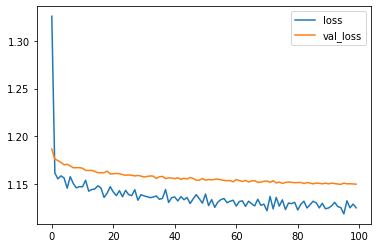

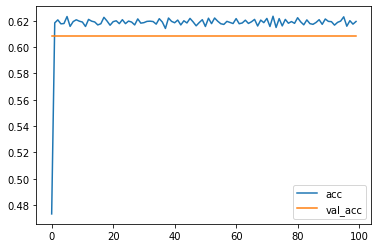

In [19]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [20]:
loss, acc = model.evaluate(testing_ds)

502/502 [==============================] - 17s 34ms/step - loss: 1.1497 - acc: 0.6082


# ResNet50をゼロから学習

## Without Augmentation

In [21]:
%%time
# get model and compile
tf.keras.backend.clear_session()

# モデルがTPU上で確実に学習されるようにするために、 strategy.scope()を使用してモデルを構築
#with strategy.scope(): 
model = get_training_model()
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="scratch_without_augment.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train 
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=25,
                    callbacks=[early_stopper, checkpoint],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE, 
                   )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
input_1 True
resnet50 True
global_average_pooling2d True
dense True

Epoch 1/25
836/836 [==============================] - 119s 143ms/step - loss: 1.2502 - acc: 0.5752 - val_loss: 1.1452 - val_acc: 0.6034
Epoch 2/25
836/836 [==========

<AxesSubplot:>

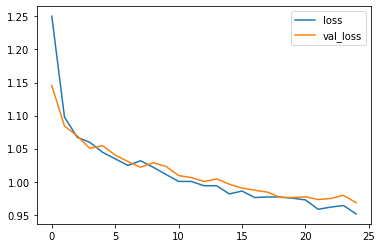

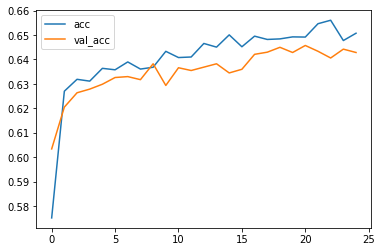

In [22]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [23]:
loss, acc = model.evaluate(testing_ds)

502/502 [==============================] - 21s 42ms/step - loss: 0.9687 - acc: 0.6450


## With Augmentation

In [24]:
trainloader = (
    train_ds
    .map(tie_together, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

trainloader = trainloader.with_options(options)

In [25]:
%%time
# get model and compile
tf.keras.backend.clear_session()

# モデルがTPU上で確実に学習されるようにするために、 strategy.scope()を使用してモデルを構築
#with strategy.scope(): 
model = get_training_model()
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="scratch_augment.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train 
history = model.fit(trainloader,
                    validation_data=(testing_ds),
                    epochs=25,
                    callbacks=[early_stopper, checkpoint],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE, 
                   )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
input_1 True
resnet50 True
global_average_pooling2d True
dense True

Epoch 1/25
836/836 [==============================] - 119s 143ms/step - loss: 1.1984 - acc: 0.6012 - val_loss: 1.1444 - val_acc: 0.6124
Epoch 2/25
836/836 [==========

<AxesSubplot:>

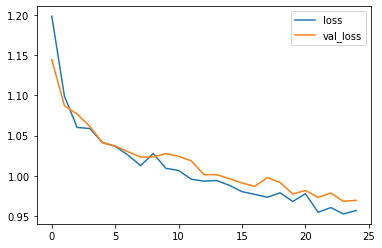

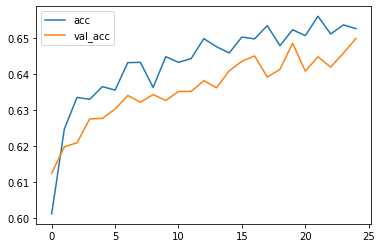

In [26]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [27]:
loss, acc = model.evaluate(testing_ds)

502/502 [==============================] - 21s 42ms/step - loss: 0.9690 - acc: 0.6514


# 10％のラベル付きデータだけでFine Tuning
- ラベル付きデータが非常に少ないケース
- 最初にSwAVの重みを凍結してトレーニング（通常、高い学習率で実行）
- 次に、全層をより低い学習率でトレーニング
- https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/fine_tuning/Fine_Tuning_Supervised_10Perc.ipynb

In [28]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(train_tfrecs,
                                                       test_size=0.35, 
                                                       random_state=5)

TRAINING_FILENAMES, extra_TRAINING_FILENAMES = train_test_split(TRAINING_FILENAMES,
                                                                test_size=0.9, 
                                                                random_state=5)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_extra_TRAINING_IMAGES = count_data_items(extra_TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
print(f"NUM_TRAINING_IMAGES, NUM_extra_TRAINING_IMAGES, NUM_VALIDATION_IMAGES: {NUM_TRAINING_IMAGES}, {NUM_extra_TRAINING_IMAGES}, {NUM_VALIDATION_IMAGES}")

train_ds = load_dataset(TRAINING_FILENAMES, labeled=True)
extra_train_ds = load_dataset(extra_TRAINING_FILENAMES, labeled=True)
validation_ds = load_dataset(VALID_FILENAMES, labeled=True)

# 10％のラベル付きデータ
training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(256)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testing_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

NUM_TRAINING_IMAGES, NUM_extra_TRAINING_IMAGES, NUM_VALIDATION_IMAGES: 1338, 12042, 8017


## With Augmentation

In [29]:
# 10％のラベル付きデータ
trainloader = (
    train_ds
    .map(tie_together, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(256)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

trainloader = trainloader.with_options(options)

## 1.imagenetの重み固定して学習

In [30]:
%%time
# get model and compile
tf.keras.backend.clear_session()

# モデルがTPU上で確実に学習されるようにするために、 strategy.scope()を使用してモデルを構築
#with strategy.scope(): 
model = get_training_model(weights="imagenet")
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

# train
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=epochs,
                    callbacks=[early_stopper],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                   )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
input_1 True
resnet50 False
global_average_pooling2d True
dense True

Epoch 1/100
83/83 [==============================] - 21s 255ms/step - loss: 1.9036 - acc: 0.0919 - val_loss: 1.8002 - val_acc: 0.1027
Epoch 2/100
83/83 [============

83/83 [==============================] - 21s 248ms/step - loss: 1.1708 - acc: 0.6107 - val_loss: 1.1743 - val_acc: 0.6082
Epoch 55/100
83/83 [==============================] - 20s 246ms/step - loss: 1.1643 - acc: 0.6167 - val_loss: 1.1744 - val_acc: 0.6082
Epoch 56/100
83/83 [==============================] - 21s 248ms/step - loss: 1.1897 - acc: 0.6009 - val_loss: 1.1740 - val_acc: 0.6082
Epoch 57/100
83/83 [==============================] - 20s 245ms/step - loss: 1.1423 - acc: 0.6265 - val_loss: 1.1740 - val_acc: 0.6082
Epoch 58/100
83/83 [==============================] - 21s 247ms/step - loss: 1.1775 - acc: 0.6069 - val_loss: 1.1736 - val_acc: 0.6082
Epoch 59/100
83/83 [==============================] - 21s 248ms/step - loss: 1.1741 - acc: 0.6114 - val_loss: 1.1733 - val_acc: 0.6082
Epoch 60/100
83/83 [==============================] - 21s 247ms/step - loss: 1.1618 - acc: 0.6145 - val_loss: 1.1731 - val_acc: 0.6082
Epoch 61/100
83/83 [==============================] - 21s 249ms/step

In [31]:
model.save('warmup.h5')

## 2.Fine tune CNN（1.の重みロードして全層学習）

In [32]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-6,  # 学習率下げてる
    decay_steps=10000, 
    decay_rate=0.9)
    
    
def get_classifier():
    # load warmup model
    warmup_model = tf.keras.models.load_model('warmup.h5')
    warmup_model.trainable = True
    
    warmup_model.compile(loss="sparse_categorical_crossentropy", 
                         metrics=["acc"],
                         optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
                        )

    return warmup_model

In [33]:
%%time
# get model and compile
tf.keras.backend.clear_session()
full_trainable_model = get_classifier()
full_trainable_model.summary()
for l in full_trainable_model.layers:
    print(l.name, l.trainable)
print()
    
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="imagenet_finetuning.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train                                              
history = full_trainable_model.fit(training_ds,
                                   validation_data=(testing_ds),
                                   epochs=epochs*3,
                                   callbacks=[early_stopper, checkpoint],
                                   steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                                   validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                                  )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
input_1 True
resnet50 True
global_average_pooling2d True
dense True

Epoch 1/300
83/83 [==============================] - 29s 344ms/step - loss: 1.1639 - acc: 0.6122 - val_loss: 1.1542 - val_acc: 0.6082
Epoch 2/300
83/83 [=============

83/83 [==============================] - 27s 328ms/step - loss: 0.9013 - acc: 0.6694 - val_loss: 1.1030 - val_acc: 0.6022
Epoch 55/300
83/83 [==============================] - 27s 328ms/step - loss: 0.8457 - acc: 0.6913 - val_loss: 1.0718 - val_acc: 0.6122
Epoch 56/300
83/83 [==============================] - 27s 327ms/step - loss: 0.8722 - acc: 0.6755 - val_loss: 1.0758 - val_acc: 0.6316
Epoch 57/300
83/83 [==============================] - 27s 326ms/step - loss: 0.8227 - acc: 0.6980 - val_loss: 1.0855 - val_acc: 0.6289
Epoch 58/300
83/83 [==============================] - 27s 327ms/step - loss: 0.8497 - acc: 0.6807 - val_loss: 1.0877 - val_acc: 0.6301
Epoch 59/300
83/83 [==============================] - 27s 328ms/step - loss: 0.8349 - acc: 0.6883 - val_loss: 1.0680 - val_acc: 0.6225
Epoch 60/300
83/83 [==============================] - 27s 329ms/step - loss: 0.8153 - acc: 0.6973 - val_loss: 1.0964 - val_acc: 0.6319
Epoch 61/300
83/83 [==============================] - 27s 328ms/step

<AxesSubplot:>

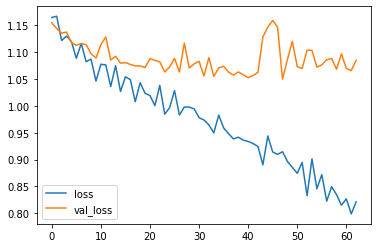

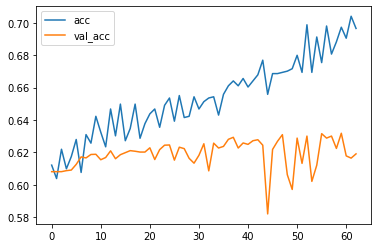

In [34]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [35]:
loss, acc = full_trainable_model.evaluate(testing_ds)

502/502 [==============================] - 17s 34ms/step - loss: 1.0493 - acc: 0.6310


# 1%のラベル付きデータだけでFine Tuning

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

df = pd.read_csv(r'C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train.csv')

n_splits = 100

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
for fold, (trn_idx, val_idx) in enumerate(skf.split(np.arange(df.shape[0]), df.label.values)):
    df.loc[df.iloc[val_idx].index, 'fold'] = fold

#df["filepath"] = f"../input/cassava-leaf-disease-classification/train_images/" + df["image_id"]
_dir = "C:\\Users\\81908\\jupyter_notebook\\pytorch_lightning_work\\kaggle_Cassava\\input\\cassava-leaf-disease-classification\\train_images\\"
df["filepath"] =  _dir + df["image_id"] #[os.path.join(_dir, p) for p in df["image_id"]]
display(df.head())

train_df = df[df["fold"] == 0]
print('train_df Class distribution per fold.\n', train_df['label'].value_counts())

print()

val35per = list(range(65,100))
validation_df = df[df["fold"].isin(val35per)]
print('validation_df Class distribution per fold.\n', validation_df['label'].value_counts())

TRAINING_FILENAMES = train_df["filepath"]
VALID_FILENAMES = validation_df["filepath"]
NUM_TRAINING_IMAGES = len(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = len(VALID_FILENAMES)

print(df["filepath"][0])

,image_id,label,fold,filepath
0,1000015157.jpg,0,67.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...
1,1000201771.jpg,3,55.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...
2,100042118.jpg,1,48.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...
3,1000723321.jpg,1,34.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...
4,1000812911.jpg,3,57.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...


train_df Class distribution per fold.
 3    132
4     25
2     24
1     22
0     11
Name: label, dtype: int64

validation_df Class distribution per fold.
 3    4598
4     907
2     840
1     770
0     372
Name: label, dtype: int64
C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train_images\1000015157.jpg


In [37]:
@tf.function
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)  # 画像パスロード
    img = tf.image.decode_jpeg(img, channels=3)  # jpegファイルロード
    img = tf.cast(img, tf.float32) / 255.0  # 正規化
    img = tf.image.resize(img, (224, 224)) # Resizing
    return img, tf.cast(label, tf.int32)  # ラベルもtf型に変換

@tf.function
def load_image_and_label_from_path_augment(image_path, label):
    img = tf.io.read_file(image_path)  # 画像パスロード
    img = tf.image.decode_jpeg(img, channels=3)  # jpegファイルロード
    img = tf.cast(img, tf.float32) / 255.0  # 正規化
    img, label = scale_image(img, label)
    img = random_apply(tf.image.random_flip_left_right, img, p=0.5)
    img, label = random_resize_crop(img, label)
    return img, tf.cast(label, tf.int32)  # ラベルもtf型に変換

# Seriesからtf.data.Datasetに変換
training_data = tf.data.Dataset.from_tensor_slices((train_df.filepath.values, train_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

AUTO = tf.data.experimental.AUTOTUNE

training_ds = (
    training_data
    .map(load_image_and_label_from_path_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(buffer_size=32)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTO)
)
training_ds.with_options(options)

testing_ds = (
    validation_data
    .map(load_image_and_label_from_path, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTO)
)

## 1.imagenetの重み固定して学習

In [38]:
%%time
# get model and compile
tf.keras.backend.clear_session()
model = get_training_model(weights="imagenet")
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

# train
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=epochs,
                    callbacks=[early_stopper],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                   )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
input_1 True
resnet50 False
global_average_pooling2d True
dense True

Epoch 1/100
13/13 [==============================] - 20s 2s/step - loss: 1.4600 - acc: 0.6106 - val_loss: 1.4464 - val_acc: 0.6144
Epoch 2/100
13/13 [===============

Epoch 56/100
13/13 [==============================] - 19s 1s/step - loss: 1.3869 - acc: 0.6058 - val_loss: 1.3659 - val_acc: 0.6142
Epoch 57/100
13/13 [==============================] - 19s 1s/step - loss: 1.3459 - acc: 0.6346 - val_loss: 1.3647 - val_acc: 0.6142
Epoch 58/100
13/13 [==============================] - 19s 1s/step - loss: 1.3689 - acc: 0.6058 - val_loss: 1.3635 - val_acc: 0.6142
Epoch 59/100
13/13 [==============================] - 19s 1s/step - loss: 1.3780 - acc: 0.6058 - val_loss: 1.3623 - val_acc: 0.6142
Epoch 60/100
13/13 [==============================] - 19s 1s/step - loss: 1.3398 - acc: 0.6202 - val_loss: 1.3611 - val_acc: 0.6142
Epoch 61/100
13/13 [==============================] - 19s 1s/step - loss: 1.3458 - acc: 0.6394 - val_loss: 1.3599 - val_acc: 0.6142
Epoch 62/100
13/13 [==============================] - 19s 1s/step - loss: 1.3600 - acc: 0.6154 - val_loss: 1.3587 - val_acc: 0.6142
Epoch 63/100
13/13 [==============================] - 19s 1s/step - loss: 1.

In [39]:
model.save('imagenet_warmup_1per.h5')

## 2.Fine tune CNN（1.の重みロードして全層学習）

In [40]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-6,  # 学習率下げてる
    decay_steps=10000, 
    decay_rate=0.9)
    
    
def get_classifier():
    # load warmup model
    warmup_model = tf.keras.models.load_model('imagenet_warmup_1per.h5')
    warmup_model.trainable = True
    
    warmup_model.compile(loss="sparse_categorical_crossentropy", 
                         metrics=["acc"],
                         optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
                        )

    return warmup_model

In [41]:
%%time
# get model and compile
tf.keras.backend.clear_session()
full_trainable_model = get_classifier()
full_trainable_model.summary()
for l in full_trainable_model.layers:
    print(l.name, l.trainable)
print()
    
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="imagenet_finetuning_1per.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train                                              
history = full_trainable_model.fit(training_ds,
                                   validation_data=(testing_ds),
                                   epochs=epochs*3,
                                   callbacks=[early_stopper, checkpoint],
                                   steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                                   validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                                  )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
input_1 True
resnet50 True
global_average_pooling2d True
dense True

Epoch 1/300
13/13 [==============================] - 22s 2s/step - loss: 1.2747 - acc: 0.6202 - val_loss: 1.2358 - val_acc: 0.6142
Epoch 2/300
13/13 [================

Epoch 56/300
13/13 [==============================] - 20s 2s/step - loss: 1.0641 - acc: 0.6202 - val_loss: 1.1089 - val_acc: 0.6142
Epoch 57/300
13/13 [==============================] - 20s 2s/step - loss: 1.0874 - acc: 0.6058 - val_loss: 1.1183 - val_acc: 0.6187
Epoch 58/300
13/13 [==============================] - 20s 2s/step - loss: 1.0170 - acc: 0.6394 - val_loss: 1.1104 - val_acc: 0.6142
Epoch 59/300
13/13 [==============================] - 20s 2s/step - loss: 1.0851 - acc: 0.6106 - val_loss: 1.1198 - val_acc: 0.6142
Epoch 60/300
13/13 [==============================] - 20s 2s/step - loss: 1.0510 - acc: 0.6394 - val_loss: 1.1068 - val_acc: 0.6146
Epoch 61/300
13/13 [==============================] - 20s 2s/step - loss: 1.1086 - acc: 0.6010 - val_loss: 1.1072 - val_acc: 0.6154
Epoch 62/300
13/13 [==============================] - 20s 2s/step - loss: 1.0829 - acc: 0.6154 - val_loss: 1.1199 - val_acc: 0.6142
Epoch 63/300
13/13 [==============================] - 20s 2s/step - loss: 1.

<AxesSubplot:>

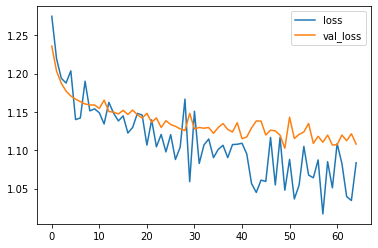

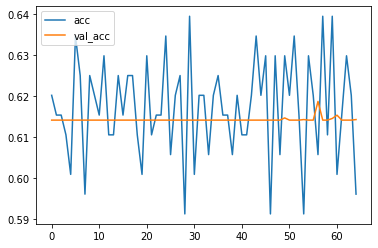

In [42]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [43]:
loss, acc = full_trainable_model.evaluate(testing_ds)

468/468 [==============================] - 19s 41ms/step - loss: 1.1026 - acc: 0.6147
